In [1]:
import pandas as pd
from gensim.models import FastText

C:\Users\Andreas\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_hdf("../../datasets/Parenting.h5", key="Parenting")

In [3]:
model_sent = FastText.load("../../models/subreddit_level/fasttext_Parenting_senti.bin")

In [4]:
NRC = pd.read_csv('../../datasets/NRC-VAD-Lexicon.txt', sep="\t", header=None, names=["Words", "valence", "arousal", "dominance"])

In [5]:
token_list = df["token_list"].tolist()
flatlist = [item for sublist in token_list for item in sublist]

In [6]:
def identify_weigths(flat_list):
    from collections import Counter
    female=["sister" , "female" , "woman" , "girl" , "daughter" , "she" , "hers" , "her"]
    male=["brother" , "male" , "man" , "boy" , "son" , "he" , "his" , "him"] 
   
    tokens = [item for sublist in flat_list for item in sublist]
    term_list_woman = []
    for i in tokens:
        if i in female:
            term_list_woman.append(i)
    counter = Counter(term_list_woman)
    
    liste_woman = []
    weights = []
    
    for i in counter:
        if counter[i] > 100:
            liste_woman.append(i)
            weights.append(counter[i])
            
    term_list_man = []
    for i in tokens:
        if i in male:
            term_list_man.append(i)
    counter = Counter(term_list_man)
    
    liste_man = []
    weights_man = []
    
    for i in counter:
        if counter[i] > 100:
            liste_man.append(i)
            weights_man.append(counter[i])
    
    return [liste_woman, weights], [liste_man, weights_man] 

In [7]:
# Calculate frequencies for the male and female terms

woman_terms_freq, man_terms_freq = identify_weigths(flatlist)

In [8]:
woman_terms_freq, man_terms_freq

([['she', 'daughter', 'her', 'woman', 'sister', 'girl', 'female', 'hers'],
  [229383, 32101, 66172, 7251, 7004, 10898, 1057, 411]],
 [['brother', 'he', 'his', 'man', 'boy', 'him', 'son', 'male'],
  [5955, 239803, 61684, 9187, 9974, 129, 33231, 1398]])

In [9]:
def calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model, NRC, n_words):
    import numpy as np
    word_vectors = model.wv
    centroid_woman = np.ma.average([word_vectors[w] for w in woman_terms_freq[0]], weights= woman_terms_freq[1] ,axis=0)

    vector_woman = word_vectors.similar_by_vector(centroid_woman,topn=n_words)
    
    liste_woman = []
    for i in vector_woman:
        liste_woman.append(i[0])
    
    print("Top 10 (woman)", liste_woman[:10])
    
    intersection_woman = list(set(liste_woman) & set(NRC["Words"]))
    
    intersection_woman_ordererd = []
    for i in vector_woman:
        if i[0] in intersection_woman:
            intersection_woman_ordererd.append(i[0])
    
    df_intersection_woman = pd.DataFrame(intersection_woman_ordererd, columns=["Words"])
    df_intersection_woman = df_intersection_woman.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    
    centroid_man = np.ma.average([word_vectors[w] for w in man_terms_freq[0]], weights= man_terms_freq[1] ,axis=0)

    vector_man = word_vectors.similar_by_vector(centroid_man,topn=n_words)
    
    
    liste_man = []
    for i in vector_man:
        liste_man.append(i[0])
    
    print("Top 10 (man)", liste_man[:10])
    
    intersection_man = list(set(liste_man) & set(NRC["Words"]))
    
    intersection_man_ordererd = []
    for i in vector_man:
        if i[0] in intersection_man:
            intersection_man_ordererd.append(i[0])
    
    df_intersection_man = pd.DataFrame(intersection_man_ordererd, columns=["Words"])
    df_intersection_man = df_intersection_man.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    return df_intersection_woman, df_intersection_man, liste_woman, liste_man

In [10]:
# Calculate the weighted centroid vectors

df_NRC_woman , df_NRC_man , liste_woman, liste_man= calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model_sent, NRC, 500)

Top 10 (woman) ['she', 'daughter', 'her', 'herself', 'hers', 'daughte', 'stepdaughter', 'sister', 'niece', 'ikr']
Top 10 (man) ['he', 'son', 'his', 'himself', 'husband', 'brother', 'stepson', 'anymore', 'him', 'even']


# Top 5 terms with the most sentiment for the female and male centroid vectors

In [11]:
df_NRC_man.sort_values("valence").head()

,Words,valence,arousal,dominance
262,shit,0.000,0.678,0.294
237,afraid,0.010,0.775,0.245
160,stink,0.042,0.481,0.180
274,useless,0.052,0.342,0.184
155,hurt,0.062,0.773,0.291


In [12]:
df_NRC_man.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
222,excited,0.908,0.931,0.709
145,cheater,0.104,0.920,0.333
121,frantically,0.375,0.898,0.735
150,sinister,0.125,0.896,0.581
106,wrestle,0.388,0.890,0.765


In [13]:
df_NRC_man.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
28,superman,0.945,0.794,0.929
131,controlling,0.490,0.441,0.885
165,decide,0.656,0.540,0.855
80,legit,0.747,0.427,0.849
71,father,0.812,0.333,0.824


In [14]:
df_NRC_woman.sort_values("valence").head()

,Words,valence,arousal,dominance
103,afraid,0.010,0.775,0.245
262,hell,0.020,0.918,0.565
134,displease,0.021,0.702,0.286
251,horribly,0.050,0.631,0.454
75,freak,0.052,0.839,0.464


In [15]:
df_NRC_woman.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
174,excite,0.823,0.950,0.668
184,hysterical,0.290,0.942,0.398
191,excited,0.908,0.931,0.709
262,hell,0.020,0.918,0.565
100,distraught,0.115,0.903,0.264


In [16]:
df_NRC_woman.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
56,decide,0.656,0.540,0.855
96,able,0.786,0.500,0.810
115,thrilled,0.898,0.818,0.807
229,essentially,0.750,0.373,0.802
77,first,0.625,0.500,0.788


# Pretesting the distribution of the sentiment scores 

In [17]:
print(df_NRC_man["valence"].var(),df_NRC_man["arousal"].var(),df_NRC_man["dominance"].var() )

0.04906090445468508 0.03231419199948798 0.02664934550691242


In [18]:
print(df_NRC_woman["valence"].var(),df_NRC_woman["arousal"].var(),df_NRC_woman["dominance"].var() )

0.05886691027905788 0.03244048663594472 0.025025190937019978


In [19]:
def check_normal_dist(df,subject, gender):
    import scipy.stats as stats
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    from scipy import stats

    z =  (df[subject]- np.mean(df[subject]))/np.std(df[subject])
    stats.probplot(z, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot ({gender})")
    plt.show()

    print("Kolmogorov–Smirnov test:", stats.kstest(df[subject],
               stats.norm.cdf))

## Visualization of the QQ-Plot based on https://towardsdatascience.com/q-q-plots-explained-5aa8495426c0


Bad key figure.labelsize in file C:\Users\Andreas\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\classic (2).mplstyle, line 310 ('figure.labelsize:   medium    # size of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key figure.labelweight in file C:\Users\Andreas\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\classic (2).mplstyle, line 311 ('figure.labelweight: normal    # weight of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution


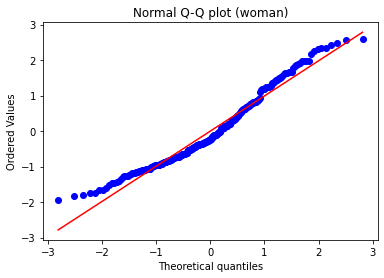

Kolmogorov–Smirnov test: KstestResult(statistic=0.5576237036360329, pvalue=1.6894060567528484e-82)


In [20]:
check_normal_dist(df_NRC_woman, "arousal", "woman")

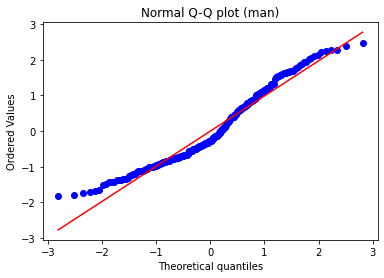

Kolmogorov–Smirnov test: KstestResult(statistic=0.5644672561017766, pvalue=1.0097216494468244e-84)


In [21]:
check_normal_dist(df_NRC_man, "arousal","man")

# Testing for statistical significance with Welsh's t-test

In [22]:
def apply_welch_test(df_1,df_2,score_type):
    from scipy.stats import ttest_ind
    from scipy.stats import levene 
    import math
    import statistics
    print(score_type)
    stat, p = ttest_ind(df_1[score_type].tolist(),df_2[score_type].tolist(), nan_policy="omit", alternative="two-sided",equal_var=False )#, equal_var=False)
    alpha = 0.05
    print("Statistics=%3f, p=%.3f" % (stat, p))
    if p < alpha:
        print("Different distributions (reject H0)")
        if df_1[score_type].mean() > df_2[score_type].mean():
            print(f"Average {score_type} for female terms is bigger:", df_1[score_type].mean(), ">" , df_2[score_type].mean())
        else:
            print(f"Average {score_type} for male terms is bigger:", df_2[score_type].mean(), ">" , df_1[score_type].mean())
    else:
        print("Same distribution (fail to reject H0)")
    if p < alpha:
        d = (df_1[score_type].mean() - df_2[score_type].mean())/math.sqrt(((df_1[score_type].var() + df_2[score_type].var())/2))
        
        print( "Cohens D:", d)
    print("Amount female terms:", len(df_1), ", Amount male terms:", len(df_2))
    print("------------------------------")

In [23]:
apply_welch_test(df_NRC_woman, df_NRC_man,"valence")
apply_welch_test(df_NRC_woman, df_NRC_man,"arousal")
apply_welch_test(df_NRC_woman, df_NRC_man,"dominance")

valence
Statistics=0.761289, p=0.447
Same distribution (fail to reject H0)
Amount female terms: 280 , Amount male terms: 280
------------------------------
arousal
Statistics=-0.389142, p=0.697
Same distribution (fail to reject H0)
Amount female terms: 280 , Amount male terms: 280
------------------------------
dominance
Statistics=-0.256323, p=0.798
Same distribution (fail to reject H0)
Amount female terms: 280 , Amount male terms: 280
------------------------------
